In [1]:
!pip install pandas geopandas matplotlib faker pyspark pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 3.9 MB/s eta 0:00:0000:0100:01
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:

In [2]:
#### Capa bronze data cruda
####
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, DoubleType, IntegerType, TimestampType

# Crear sesión de Spark
spark = SparkSession \
    .builder \
    .appName("SparkStreamingFromSocket") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

# Definir el esquema para los datos JSON que se recibirán
schema = StructType() \
    .add("latitude", DoubleType()) \
    .add("longitude", DoubleType()) \
    .add("date", TimestampType()) \
    .add("customer_id", StringType()) \
    .add("employee_id", StringType()) \
    .add("quantity_products", IntegerType()) \
    .add("order_id", StringType()) \
    .add("commune_code", StringType()) \
    .add("commune_name", StringType()) \
    .add("customer_name", StringType()) \
    .add("employee_name", StringType()) \
    .add("employee_commission", DoubleType())

# Leer datos desde el socket
streaming_df = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 12345) \
    .load()

# Parsear los datos JSON utilizando el esquema definido
parsed_df = streaming_df \
    .select(from_json(col("value").cast("string"), schema).alias("parsed_value")) \
    .select("parsed_value.*")

# Función para guardar los datos recibidos en bronze
def process_data(df, epoch_id):
    try:
        hdfs_path = "/user/root/bronze"
        df.write \
          .format("parquet") \
          .mode("append") \
          .save(hdfs_path)
        df.show(truncate=False)
    except Exception as e:
        print(f"Error al procesar los datos: {e}")

# Escribir los resultados en la consola
query = parsed_df \
    .writeStream \
    .foreachBatch(process_data) \
    .outputMode("append") \
    .start()

# Mantener el stream en ejecución
query.awaitTermination()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+--------+---------+----+-----------+-----------+-----------------+--------+------------+------------+-------------+-------------+-------------------+
|latitude|longitude|date|customer_id|employee_id|quantity_products|order_id|commune_code|commune_name|customer_name|employee_name|employee_commission|
+--------+---------+----+-----------+-----------+-----------------+--------+------------+------------+-------------+-------------+-------------------+
+--------+---------+----+-----------+-----------+-----------------+--------+------------+------------+-------------+-------------+-------------------+



+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+---------------+---------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                         |customer_name  |employee_name  |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+---------------+---------------+-------------------+
|6.181192492466105|-75.63709263421181|2023-01-12 16:40:53|1616       |9438       |78               |8329676330|80          |CORREGIMIENTO DE SAN ANTONIO DE PRADO|Nichole Ramos  |Dacey Barr     |0.02               |
|6.255259475348306|-75.50817439553738|2023-02-20 10:55:32|1958       |6337       |48               |3484395524|90          |CORREGIMIENTO DE

+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+--------------+-----------------+-------------------+
|latitude          |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name |employee_name    |employee_commission|
+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+--------------+-----------------+-------------------+
|6.202446390945579 |-75.69778675852922|2023-07-16 17:29:40|7439       |9726       |74               |6368740046|80          |CORREGIMIENTO DE SAN ANTONIO DE PRADO     |Ralph Wagner  |Christen Hamilton|0.17               |
|6.335956833969847 |-75.68226019626455|2024-01-06 01:03:34|8111       |6659       |44               |3782322694|


KeyboardInterrupt



In [3]:
#### Capa silver procesamiento
####
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, expr, round, lit, year, month, dayofmonth, trim, hour, minute, second, dayofweek
import os 

# Obtener la sesión de Spark existente si está activa
spark = SparkSession.builder.getOrCreate()

# Función para leer archivos Parquet desde HDFS
def leer_archivos_parquet(path: str) -> DataFrame:
    try:
        # Verificar la existencia del archivo antes de leerlo
        if os.system(f"hdfs dfs -test -e {path}") == 0:
            return spark.read.parquet(path)
        else:
            print(f"El archivo Parquet {path} no existe.")
            return None
    except Exception as e:
        print(f"Error al leer el archivo Parquet {path}: {e}")
        return None
    
# Ruta de bronze
bronze_path = "hdfs:///user/root/bronze"  

# Leer archivos Parquet desde el directorio en HDFS
df_bronze = leer_archivos_parquet(bronze_path)

# Función para agregar una columna con valor constante al precio y dividir la fecha
def transformar_df(df: DataFrame) -> DataFrame:
        df_transformado = df \
            .withColumn("price", lit(3500)) \
            .withColumn("sales", col("quantity_products") * col("price")) \
            .withColumn("commission_value", round(col("sales") * col("employee_commission"), 0)) \
            .withColumn("customer_name", trim(col("customer_name"))) \
            .withColumn("employee_name", trim(col("employee_name"))) \
            .withColumn("commune_name", trim(col("commune_name"))) \
            .withColumn("year", year(col("date"))) \
            .withColumn("month", month(col("date"))) \
            .withColumn("day", dayofmonth(col("date"))) \
            .withColumn("day_week", dayofweek(col("date"))) \
            .withColumn("hour", hour(col("date"))) \
            .withColumn("minute", minute(col("date"))) \
            .withColumn("second", second(col("date")))
        return df_transformado

# Función para guardar DataFrame en un archivo Parquet en la capa Silver, siempre sobreescribe esto es compactar
def guardar_archivo_parquet(df: DataFrame, path: str) -> None:
    df.coalesce(1).write \
        .mode("append") \
        .parquet(path)
        
# Función principal para unir archivos de Bronze a Silver
def unir_archivos_bronze_a_silver(bronze_path: str, silver_path: str) -> None:
    # Leer archivos Parquet desde la capa Bronze
    df_bronze = leer_archivos_parquet(bronze_path)

    # Transformar el DataFrame de Bronze
    df_transformado = transformar_df(df_bronze)

    # Guardar el DataFrame transformado en la capa Silver
    guardar_archivo_parquet(df_transformado, silver_path)

    # Leer archivos Parquet desde la capa Silver después de transformar
    df_silver_transformado = leer_archivos_parquet(silver_path)

    if df_silver_transformado is not None:
        # Contar la cantidad de registros en la capa Silver después de transformar
        records_processed = df_silver_transformado.count()
        print(f"Cantidad de registros procesados en silver después de transformar: {records_processed}")
    
    # Mostrar el DataFrame transformado (opcional)
    #df_transformado.printSchema()
    #df_transformado.show()

# Rutas en hdfs (distrbuido)
bronze_path = "hdfs:///user/root/bronze"  
silver_path = "hdfs:///user/root/silver/unificado.parquet"  

# Ejecutar el proceso de unión
unir_archivos_bronze_a_silver(bronze_path, silver_path)


Cantidad de registros procesados en silver después de transformar: 10


In [4]:
#### Capa gold
####
from pyspark.sql import SparkSession 
from pyspark.sql.functions import sum, max, min, avg, count, col

# Obtener la sesión de Spark existente si está activa
spark = SparkSession.builder.getOrCreate()

# Ruta del archivo Parquet en la capa Silver
silver_path = "hdfs:///user/root/silver/unificado.parquet"

# Leer los datos desde el archivo Parquet en la capa Silver
df = spark.read.parquet(silver_path)

# Crear la base de datos si no existe
spark.sql("CREATE DATABASE IF NOT EXISTS UNALwater")

# Establecer la base de datos en uso
spark.sql("USE UNALwater")

# Definir la ruta en HDFS donde se guardará la tabla en formato Parquet en la capa Gold
gold_path = "hdfs:///user/root/gold/UNALWater"

# Insertar el dataframe en una tabla externa UNALWater particionada por el campo 'date'
df.write.mode("append") \
  .partitionBy("date") \
  .format("parquet") \
  .option("path", gold_path) \
  .saveAsTable("UNALWater")

# Mostrar la estructura de la tabla
print("Estructura de la tabla UNALWater:")
spark.sql("DESCRIBE UNALWater").show()

# Construir y ejecutar consultas SQL para responder preguntas de negocio
query_ventas_por_comuna = """
    SELECT 
        CASE 
            WHEN commune_name LIKE '%CORREGIMIENTO DE SAN SEBAS%' THEN 'SAN SEBASTIAN DE PALMITAS'
            WHEN commune_name LIKE '%CORREGIMIENTO DE SAN CRIS%' THEN 'SAN CRISTOBAL'
            WHEN commune_name = 'CORREGIMIENTO DE ALTAVISTA' THEN 'ALTAVISTA'
            WHEN commune_name = 'CORREGIMIENTO DE SANTA ELENA' THEN 'SANTA ELENA'
            WHEN commune_name = 'CORREGIMIENTO DE SAN ANTONIO DE PRADO' THEN 'SAN ANTONIO DE PRADO'
        ELSE commune_name END AS Comuna_Corregimiento,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas
    FROM UNALWater
    GROUP BY Comuna_Corregimiento
    ORDER BY Total_Ventas DESC;
"""

query_ventas_por_vendedor = """
    SELECT 
        employee_name AS Vendedor,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas,
        SUM(commission_value) AS Valor_Comision
    FROM UNALWater
    GROUP BY employee_name
    ORDER BY Valor_Comision DESC
"""

query_top10_por_clientes = """
    SELECT 
        customer_name AS Cliente,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas
    FROM UNALWater
    GROUP BY customer_name
    ORDER BY Total_Ventas DESC
    LIMIT 10
"""

query_ventas_por_dia = """
    SELECT 
        CASE 
            WHEN day_week = 1 THEN 'Domingo' 
            WHEN day_week = 2 THEN 'Lunes' 
            WHEN day_week = 3 THEN 'Martes'
            WHEN day_week = 4 THEN 'Miércoles'
            WHEN day_week = 5 THEN 'Jueves'
            WHEN day_week = 6 THEN 'Viernes'
            WHEN day_week = 7 THEN 'Sábado'
        END AS Dia_Semana,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas
    FROM UNALWater
    GROUP BY day_week
    ORDER BY Total_Ventas DESC
"""

# Ejecutar las consultas SQL y mostrar los resultados
ventas_por_comuna = spark.sql(query_ventas_por_comuna)
print("Comportamiento de la cantidad de ventas por comuna:")
ventas_por_comuna.show()

ventas_por_vendedor = spark.sql(query_ventas_por_vendedor)
print("Comportamiento de la cantidad de ventas por vendedor:")
ventas_por_vendedor.show()

top10_por_clientes = spark.sql(query_top10_por_clientes)
print("Los 10 clientes que más nos han comprado botellas de agua:")
top10_por_clientes.show()

ventas_por_dia = spark.sql(query_ventas_por_dia)
print("Comportamiento de ventas de botellas de agua por día de la semana:")
ventas_por_dia.show()



Estructura de la tabla UNALWater:
+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|           latitude|   double|   null|
|          longitude|   double|   null|
|        customer_id|   string|   null|
|        employee_id|   string|   null|
|  quantity_products|      int|   null|
|           order_id|   string|   null|
|       commune_code|   string|   null|
|       commune_name|   string|   null|
|      customer_name|   string|   null|
|      employee_name|   string|   null|
|employee_commission|   double|   null|
|              price|      int|   null|
|              sales|      int|   null|
|   commission_value|   double|   null|
|               year|      int|   null|
|              month|      int|   null|
|                day|      int|   null|
|           day_week|      int|   null|
|               hour|      int|   null|
|             minute|      int|   null|
+-------------------+---------+-------+
only s

+--------------------+------------------+------------+
|Comuna_Corregimiento|Cantidad_Productos|Total_Ventas|
+--------------------+------------------+------------+
|SAN ANTONIO DE PRADO|               152|      532000|
|SAN SEBASTIAN DE ...|               103|      360500|
|            GUAYABAL|                91|      318500|
|           ALTAVISTA|                75|      262500|
|         SANTA ELENA|                72|      252000|
|       SAN CRISTOBAL|                41|      143500|
|            MANRIQUE|                38|      133000|
+--------------------+------------------+------------+

Comportamiento de la cantidad de ventas por vendedor:
+-----------------+------------------+------------+--------------+
|         Vendedor|Cantidad_Productos|Total_Ventas|Valor_Comision|
+-----------------+------------------+------------+--------------+
|Christen Hamilton|               133|      465500|       79135.0|
|    Elijah Parker|                75|      262500|       34125.0|
|    

+----------+------------------+------------+
|Dia_Semana|Cantidad_Productos|Total_Ventas|
+----------+------------------+------------+
|    Jueves|               212|      742000|
|   Domingo|               165|      577500|
|    Sábado|               106|      371000|
|     Lunes|                89|      311500|
+----------+------------------+------------+



In [ ]:
#!hdfs dfs -ls /user/root/silver/unificado.parquet
#!hdfs dfs -mkdir -p /user/root/gold
#!hdfs dfs -ls /user/root/bronze
#!hdfs dfs -ls /user/root
#!hdfs dfs -copyToLocal /user/root/gold /Analitica/BigData/Final/gold
#!hdfs dfs -copyFromLocal medellin_neighborhoods.parquet /user/root/bronze
!hdfs dfs -ls /user/root/silver
!hdfs dfs -ls /user/root/gold
# !hdfs dfs -ls /user/root/bronze
#!hdfs dfs -ls /user/root/bronze | grep medellin_neighborhoods.parquet

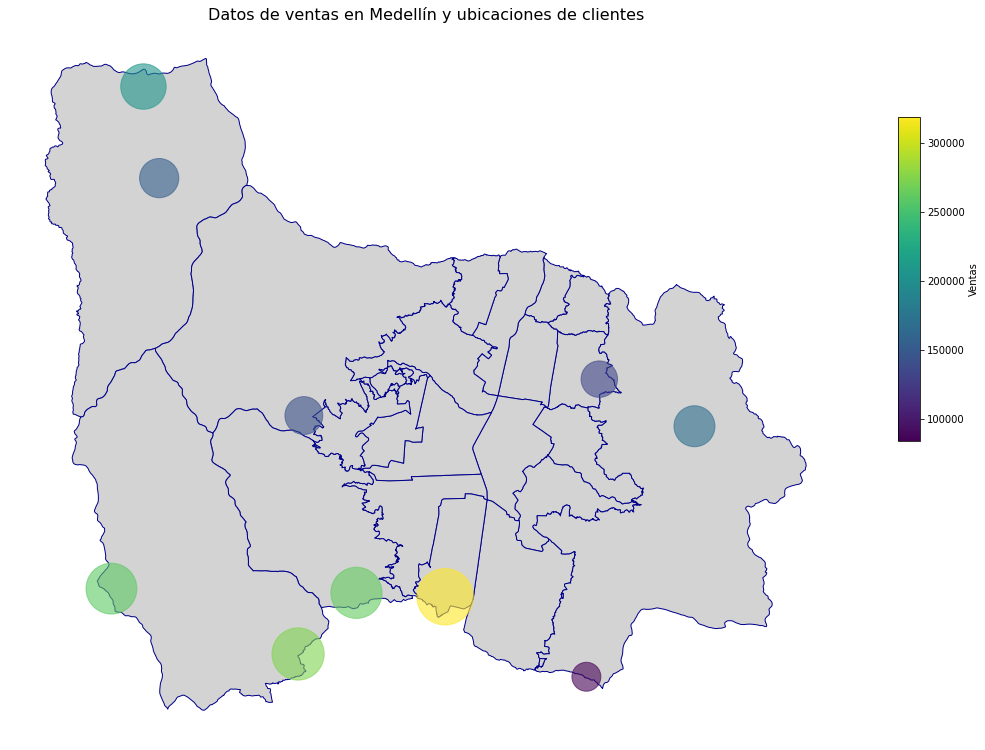

In [5]:
# Importar las librerías necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

spark = SparkSession.builder.getOrCreate()

# Definir la ruta del archivo Parquet con datos de ventas en la capa Silver
cargue_inicial_path = 'hdfs:///user/root/silver/unificado.parquet'

try:
    # Cargar el archivo Parquet de cargue inicial como un DataFrame de Spark
    df_cargue = spark.read.parquet(cargue_inicial_path)

    # Convertir las columnas de longitud y latitud a tipo Float
    df_cargue = df_cargue.withColumn('longitude', col('longitude').cast(FloatType())) \
                         .withColumn('latitude', col('latitude').cast(FloatType()))

    # Convertir el DataFrame de Spark en un DataFrame de Pandas
    df_cargue_pd = df_cargue.toPandas()

    # Crear una columna de geometría en el DataFrame de Pandas
    df_cargue_pd['geom'] = df_cargue_pd.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Convertir el DataFrame de Pandas en un GeoDataFrame de GeoPandas
    gdf_cargue = gpd.GeoDataFrame(df_cargue_pd, geometry='geom')
    
    # Cargar el archivo Parquet de geometrías de Medellín como un GeoDataFrame de GeoPandas
    medellin_neighborhoods = gpd.read_parquet('medellin_neighborhoods.parquet')

    # Crear una escala de colores basada en las ventas
    norm = mcolors.Normalize(vmin=gdf_cargue['sales'].min(), vmax=gdf_cargue['sales'].max())
    cmap = cm.ScalarMappable(norm=norm, cmap='viridis')

    # Asignar colores a cada punto basado en las ventas
    gdf_cargue['color'] = gdf_cargue['sales'].apply(lambda x: cmap.to_rgba(x))

    # Crear el gráfico con las geometrías de Medellín y los puntos del cargue inicial
    fig, ax = plt.subplots(figsize=(15, 15))
    medellin_neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='darkblue')
    
    # Graficar los puntos con tamaño proporcional a las ventas y colores variados
    gdf_cargue.plot(ax=ax, color=gdf_cargue['color'], markersize=gdf_cargue['sales'] / 100, alpha=0.6)
    
    plt.title('Datos de ventas en Medellín y ubicaciones de clientes', fontsize = 16)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.grid(False)
    
    cax = fig.add_axes([0.95, 0.45, 0.02, 0.3])
    cbar = plt.colorbar(cmap, cax=cax, orientation='vertical', label='Ventas')
    
    # Guardar la figura en un archivo si la visualización es correcta
    plt.savefig('./medellin_neighborhoods_simulacion.png')
    plt.show()
    plt.close()
    
except Exception as e:
    print(f"Error al convertir o visualizar los datos con GeoPandas: {str(e)}")

In [19]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Crear sesión de Spark
spark = SparkSession.builder.appName("ImprovedMLModel").getOrCreate()

cargue_inicial_path = 'hdfs:///user/root/silver/unificado.parquet'

# Cargar el archivo Parquet de cargue inicial como un DataFrame de Spark
df_cargue = spark.read.parquet(cargue_inicial_path)

# Convertir las columnas de longitud y latitud a tipo Float y crear columna 'geom'
df_cargue = df_cargue.withColumn('longitude', col('longitude').cast(FloatType())) \
                         .withColumn('latitude', col('latitude').cast(FloatType()))

# Seleccionar características relevantes y la variable objetivo
features = ['quantity_products', 'price', 'employee_commission', 'year', 'month', 'day', 'day_week', 'hour', 'minute', 'second']
target = 'sales'

# Filtrar filas con datos nulos en las columnas seleccionadas
df = df.select(*features, target).dropna()

print(df.head(5))

# Aplicar logaritmo a la variable objetivo
df = df.withColumn("log_sales", log(col(target)))

# Ensamblar las características en un vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Crear y entrenar un modelo más complejo (Random Forest)
rf = RandomForestRegressor(labelCol="log_sales", featuresCol="features")
rf_model = rf.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = rf_model.transform(test_data)

# Deshacer la transformación logarítmica para las predicciones
predictions = predictions.withColumn("prediction", exp(col("prediction")))

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

# Mostrar las primeras predicciones
predictions.select("features", target, "prediction").show(truncate=100)

[Row(quantity_products=59, price=3500, employee_commission=0.17, year=2024, month=6, day=13, day_week=5, hour=17, minute=18, second=41, sales=206500), Row(quantity_products=74, price=3500, employee_commission=0.17, year=2023, month=7, day=16, day_week=1, hour=17, minute=29, second=40, sales=259000), Row(quantity_products=44, price=3500, employee_commission=0.06, year=2024, month=1, day=6, day_week=7, hour=1, minute=3, second=34, sales=154000), Row(quantity_products=78, price=3500, employee_commission=0.02, year=2023, month=1, day=12, day_week=5, hour=16, minute=40, second=53, sales=273000), Row(quantity_products=41, price=3500, employee_commission=0.07, year=2023, month=11, day=13, day_week=2, hour=22, minute=44, second=51, sales=143500)]
RMSE: 151253.30469200216
+------------------------------------------------------+------+------------------+
|                                              features| sales|        prediction|
+------------------------------------------------------+----

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Crear sesión de Spark
spark = SparkSession.builder.appName("GeoMLModel").getOrCreate()

# Cargar datos desde archivo Parquet
df = spark.read.parquet("ruta/al/archivo.parquet")

# Seleccionar características relevantes (latitude, longitude) y la variable objetivo (sales)
features = ['latitude', 'longitude']
target = 'sales'

# Filtrar filas con datos nulos en las columnas seleccionadas
df = df.select(*features, target).dropna()

# Ensamblar las características en un vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Crear y entrenar el modelo de regresión lineal
lr = LinearRegression(labelCol=target, featuresCol="features")
lr_model = lr.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = lr_model.transform(test_data)

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mostrar las primeras predicciones
predictions.select("features", target, "prediction").show(5, truncate=100)

AnalysisException: Path does not exist: hdfs://0.0.0.0:9000/user/root/ruta/al/archivo.parquet